In [2]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

In [3]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions
using FreqTables

In [4]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [9]:
import Base: copy

struct LinstabScanTester_SAR{F}
    ks::Vector{F}
    M1::Matrix{F}
    M::Matrix{F}
    threshold::F
    function LinstabScanTester_SAR(ks, N, threshold=2 * eps())
        M1 = Matrix{eltype(ks)}(undef, N, N)
        M = Matrix{eltype(ks)}(undef, N, N)
        new{eltype(ks)}(ks, M1, M, threshold)
    end
end
function LinstabScanTester_SAR(ks, p::AbstractMMiCRMParams, threshold=2 * eps())
    LinstabScanTester(ks, sum(get_Ns(p)), threshold)
end
function (lt::LinstabScanTester_SAR)(sp::AbstractSMMiCRMParams, ss)
    make_M1!(lt.M1, sp, ss)

    evals = eigvals(lt.M1)
    if any(l -> real(l) > 0., evals)
        return -1
    end

    for k in lt.ks
        lt.M .= lt.M1
        M1_to_M!(lt.M, get_Ds(sp), k)
        evals = eigvals!(lt.M)
        if any(l -> real(l) > lt.threshold, evals)
            return 1
        end
    end
    return 2
end
function copy(lst::LinstabScanTester_SAR)
    LinstabScanTester_SAR(lst.ks, size(lst.M)[1], lst.threshold)
end

copy (generic function with 464 methods)

In [ ]:
# can add a copy of example_do_rg_run if we need more flexibility
function do_rg_run(rg, num_repeats, ks;
    extinctthreshold=1e-8,
    maxresidthreshold=1e-9,
    linstabthreshold=100 * eps(),
    return_interesting=false
)
    @time "Generating one params" sample_params = rg()
    flush(stdout)
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # prep for the run
    lst = LinstabScanTester_SAR(ks, N, linstabthreshold)

    rslts = fill(0, num_repeats)
    interesting_systems = []

    @tasks for i in 1:num_repeats
        @local llst = copy(lst)

        params = rg()

        result = 0
        interesting = false

        # numerically solve for the steady state
        u0 = ModifiedMiCRM.make_u0_onlyN(params)
        ssp = make_mmicrm_ss_problem(params, u0)
        ssps = solve(ssp, DynamicSS(TRBDF2());
            reltol=maxresidthreshold,
            isoutofdomain=(u,_,_)-> any(x -> x < 0., u),
            maxiters=1000000
        )

        if SciMLBase.successful_retcode(ssps.retcode)
            warning = false
            maxresid = maximum(abs, ssps.resid)
            if maxresid > maxresidthreshold * 100
                @warn (@sprintf "maxresid reached is %g which is close to %g" maxresid (maxresidthreshold * 100))
                warning = true
            end

            if all(x -> abs(x) < extinctthreshold, ssps.u[1:Ns])
                result = -101 # gone extinct in nospace ss
            end

            linstab_result = llst(params, ssps.u)
            if !warning
                if linstab_result == 1
                    result = 2 # spatial instability
                    interesting = true
                elseif linstab_result == 2
                    result = 1 # stable
                else
                    result = 3 # stable but may be wrong
                end
            else
                if linstab_result == 1
                    result = -2 # spatial instability but may be wrong
                elseif linstab_result == 2
                    result = -1 # stable but may be wrong
                else
                    result = -3 # stable but may be wrong
                end
            end
        else
            result = -100
        end

        rslts[i] = result
        if return_interesting && interesting
            push!(interesting_systems, params)
        end

        # @printf "Run %d -> %d\n" i rslts[i]
        # flush(stdout)
    end

    if !return_interesting
        rslts
    else
        rslts, interesting_systems
    end
end

do_rg_run (generic function with 1 method)

# Testing

In [24]:
rsg = RSGJans1(20, 20;
    m=0.5,
    r=0.1,
    Kp=1., K=0.5,
    
    c=2.,
    l=0.8,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    DS=1e-8, DR=1.,
)
@time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000)[2:end];
    extinctthreshold=1e-5, 
    linstabthreshold=1e-10,
    maxresidthreshold=1e-5
)
freqtable(xx)

Generating one params: 0.000048 seconds (226 allocations: 78.797 KiB)


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


1308.656086 seconds (31.07 M allocations: 4.904 GiB, 2.32% gc time)


4-element Named Vector{Int64}
Dim1  │ 
──────┼───
-100  │  2
1     │ 37
2     │ 26
3     │ 35

shape of D: (1, 20, 20)


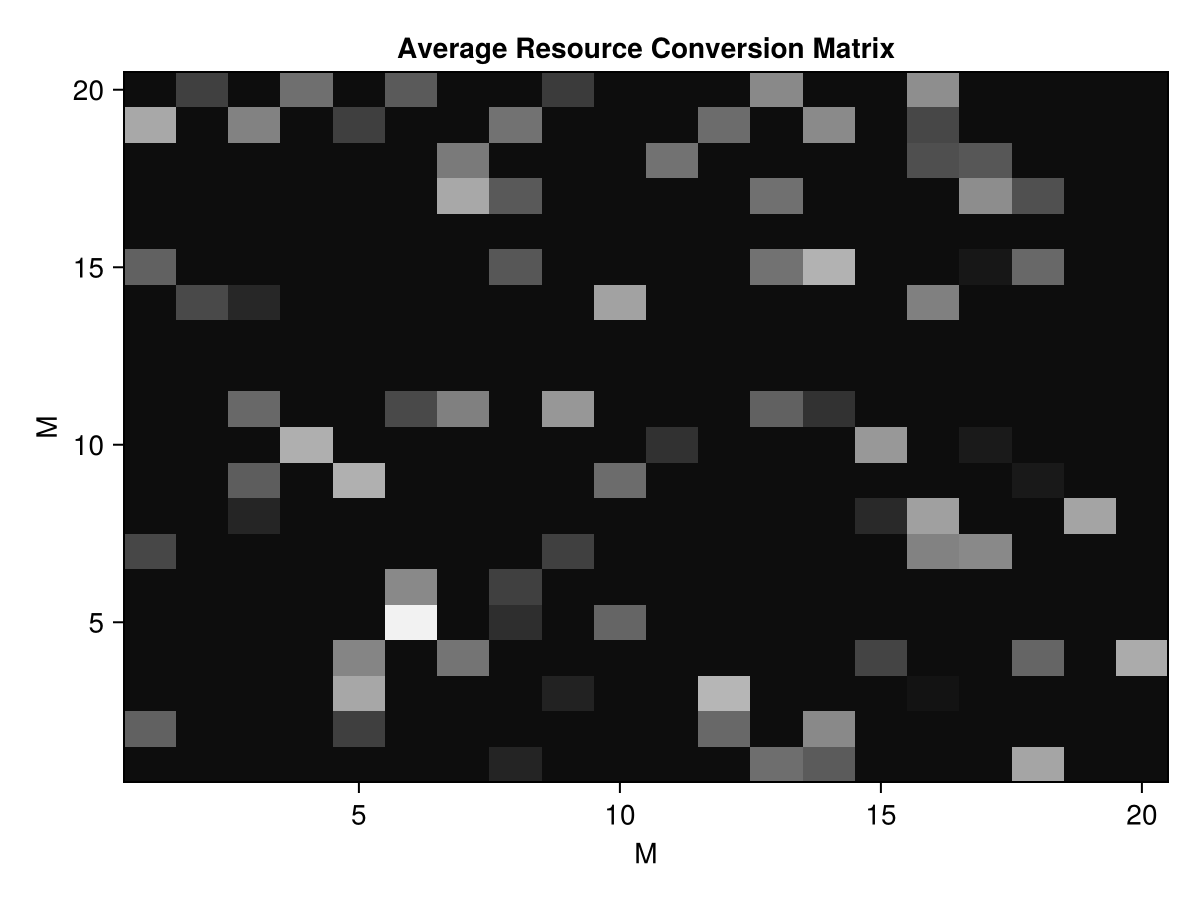

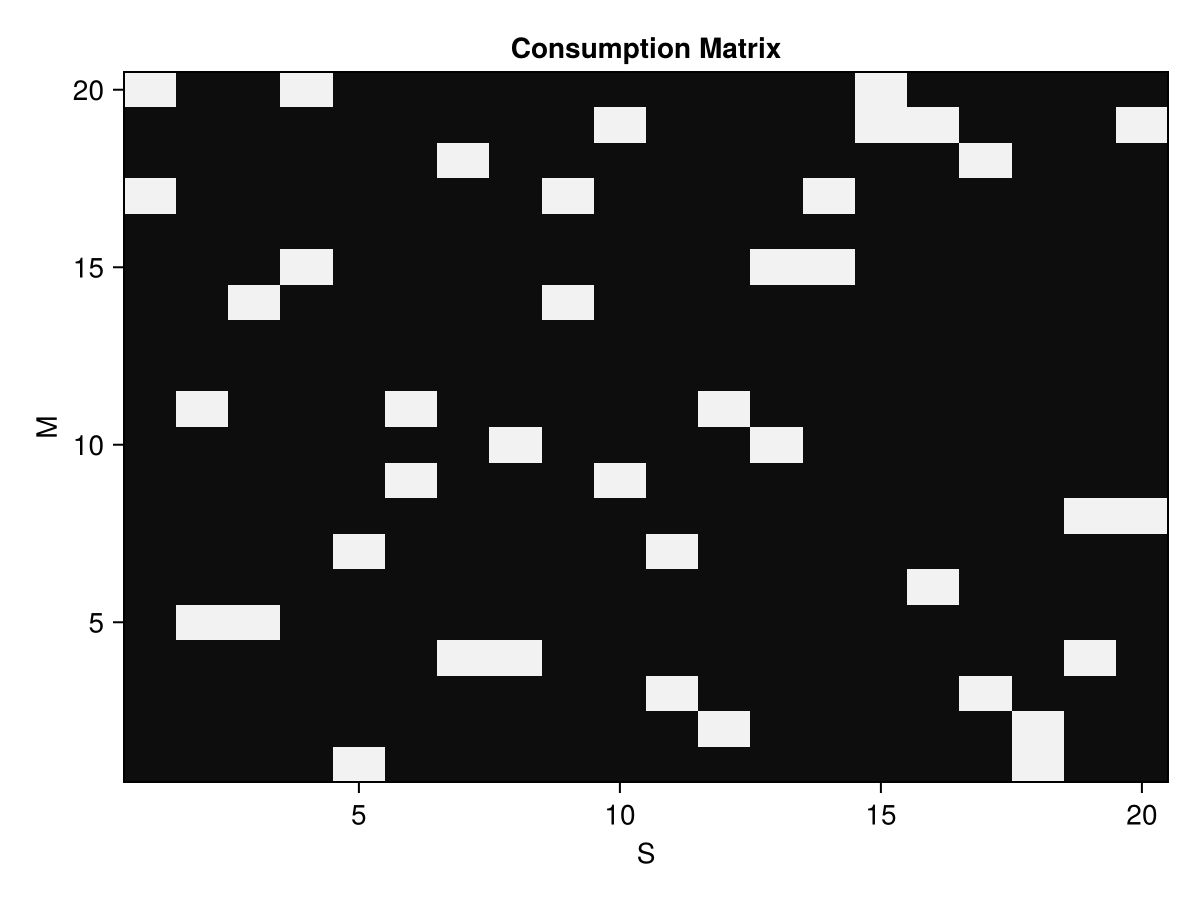

In [ ]:
rsg = RSGJans1(20, 20;
    m=0.5,
    r=0.1,
    Kp=1., K=0.5,
    
    c=2.,
    l=0.8,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    DS=1e-8, DR=1.,
)

params = rsg()
D = params.D
av_D = mean(D, dims=1)
#println("shape of D: ", size(av_D))
c = params.c

# display the sampled matrices
function display_matrix(m,ttl,xlab,ylab)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel = xlab, ylabel=ylab, title=ttl)
    heatmap!(ax, m,colormap = :grays)
    fig
end

display(display_matrix(av_D[1,:,:],"Average Resource Conversion Matrix", "M", "M"))

display_matrix(c,"Consumption Matrix", "S", "M")

In [31]:
xx[xx .< 2] .= 0

perc = sum(xx)/(2*length(xx))

0.4

In [ ]:
rsg = RSGStevens1(20, 20,
    0.1,
    10,
    0.1
)
@time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6
)
freqtable(xx)

Generating one params: 0.000218 seconds (113 allocations: 80.406 KiB)


┌ Warning: maxresid reached is 1.35046e-08 which is close to 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:48
┌ Warning: maxresid reached is 2.01571e-08 which is close to 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:48
┌ Warning: maxresid reached is 1.12607e-08 which is close to 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:48
┌ Warning: maxresid reached is 1.16132e-08 which is close to 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:48
┌ Warning: maxresid reached is 1.9655e-08 which is close to 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems /Users/stevenredford/Dropbox/Python/S

InterruptException: InterruptException:

In [18]:
mars = MarslandSampler1(20, 20
)
@time xx = do_rg_run(mars, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-5
)
freqtable(xx)

Generating one params: 0.002697 seconds (2.29 k allocations: 319.969 KiB)


┌ Warning: maxresid reached is 1.05386e-07 which is close to 1e-07
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:36


 15.755967 seconds (13.02 M allocations: 4.241 GiB, 16.96% gc time, 4.36% compilation time)


3-element Named Vector{Int64}
Dim1  │ 
──────┼───
-1    │  1
1     │ 95
2     │  4

In [38]:
sizes = LinRange(10, 100, 10)
println(sizes[2])


20.0


## Now we'll try instability as a function of some stuff

In [51]:
# first overall system size
npts = 10
sizes = LinRange(5, 50, 10)
prop = fill(0., npts)

for i in 1:npts
    sz = ceil(sizes[i])
    println("size: ", sz)
    rsg = RSGJans1(sz, sz;
        m=0.5,
        r=0.1,
        Kp=1., K=0.5,

        c=2.,
        l=0.5,
        sparsity_resources=0.1,
        sparsity_byproducts=0.1,

        DS=1e-8, DR=1.,
    )
    println("params made")
    @time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000)[2:end];
        extinctthreshold=1e-5, 
        linstabthreshold=1e-10,
        maxresidthreshold=1e-10
    )
    xx[xx .< 2] .= 0
    xx[xx .> 2] .= 0
    prop[i] = sum(xx)/(2*length(xx))
    println("size: ", sz, " prop: ", prop[i])
end

size: 5.0
params made
Generating one params: 0.000838 seconds (28 allocations: 2.672 KiB)
  3.907781 seconds (3.10 M allocations: 523.991 MiB, 41.42% gc time, 30.22% compilation time: 100% of which was recompilation)
size: 5.0 prop: 0.0
size: 10.0
params made
Generating one params: 0.000233 seconds (84 allocations: 12.953 KiB)


┌ Warning: maxresid reached is 1.0235e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.06023e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.0393e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.03576e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.04066e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached

  6.964234 seconds (2.98 M allocations: 765.648 MiB, 4.08% gc time)
size: 10.0 prop: 0.0
size: 15.0
params made
Generating one params: 0.000018 seconds (174 allocations: 37.953 KiB)


┌ Warning: maxresid reached is 7.1471e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 9.36455e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 5.88913e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 3.87712e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 9.60469e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reache

2145.683802 seconds (110.43 M allocations: 12.326 GiB, 5.61% gc time)
size: 15.0 prop: 0.0
size: 20.0
params made
Generating one params: 0.001413 seconds (226 allocations: 78.797 KiB)


┌ Warning: maxresid reached is 4.23483e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 4.73464e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 9.55035e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 4.4764e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 3.93758e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reache

InterruptException: InterruptException:

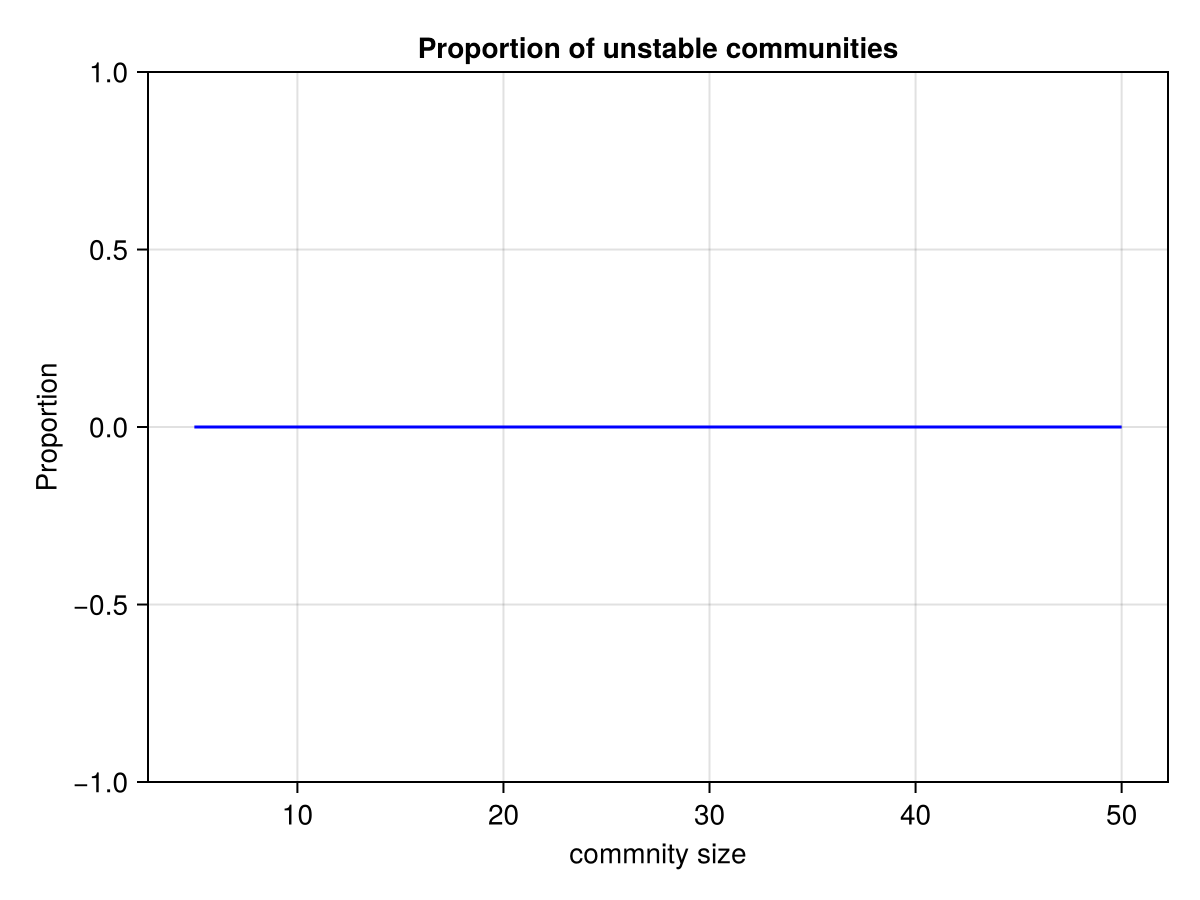

CairoMakie.Screen{IMAGE}


In [52]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities", xlabel="commnity size", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

In [16]:
# now static resource size
npts = 10
sizes = LinRange(5, 50, 10)
M = 20
prop = fill(0., npts)

for i in 1:npts
    sz = ceil(sizes[i])
    #println("size: ", sz)
    rsg = RSGJans1(sz, M;
        m=0.5,
        r=0.3,
        Kp=1., K=0.5,

        c=2.,
        l=0.5,
        sparsity_resources=0.1,
        sparsity_byproducts=0.1,

        DS=1e-8, DR=1.,
    )
    #println("params made")
    @time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000)[2:end];
        extinctthreshold=1e-5, 
        linstabthreshold=1e-10,
        maxresidthreshold=1e-10
    )
    xx[xx .< 2] .= 0
    prop[i] = sum(xx)/(2*length(xx))
    #println("size: ", sz, " prop: ", prop[i])
end

Generating one params: 0.000023 seconds (74 allocations: 20.984 KiB)
  3.687128 seconds (11.45 M allocations: 3.863 GiB, 10.65% gc time, 43.21% compilation time)
Generating one params: 0.000011 seconds (124 allocations: 40.188 KiB)
  4.793598 seconds (6.39 M allocations: 3.434 GiB, 5.67% gc time)
Generating one params: 0.000010 seconds (176 allocations: 59.516 KiB)
  7.944719 seconds (8.13 M allocations: 2.893 GiB, 25.91% gc time)
Generating one params: 0.000018 seconds (226 allocations: 78.797 KiB)
  6.097170 seconds (9.75 M allocations: 2.196 GiB, 2.16% gc time)
Generating one params: 0.000018 seconds (276 allocations: 98.250 KiB)
  7.475387 seconds (11.77 M allocations: 2.199 GiB, 2.79% gc time)
Generating one params: 0.000019 seconds (326 allocations: 117.516 KiB)
  5.924995 seconds (13.52 M allocations: 1.723 GiB, 2.21% gc time)
Generating one params: 0.000013 seconds (376 allocations: 136.734 KiB)
  7.422500 seconds (22.67 M allocations: 1.972 GiB, 5.44% gc time, 22.79% compilati

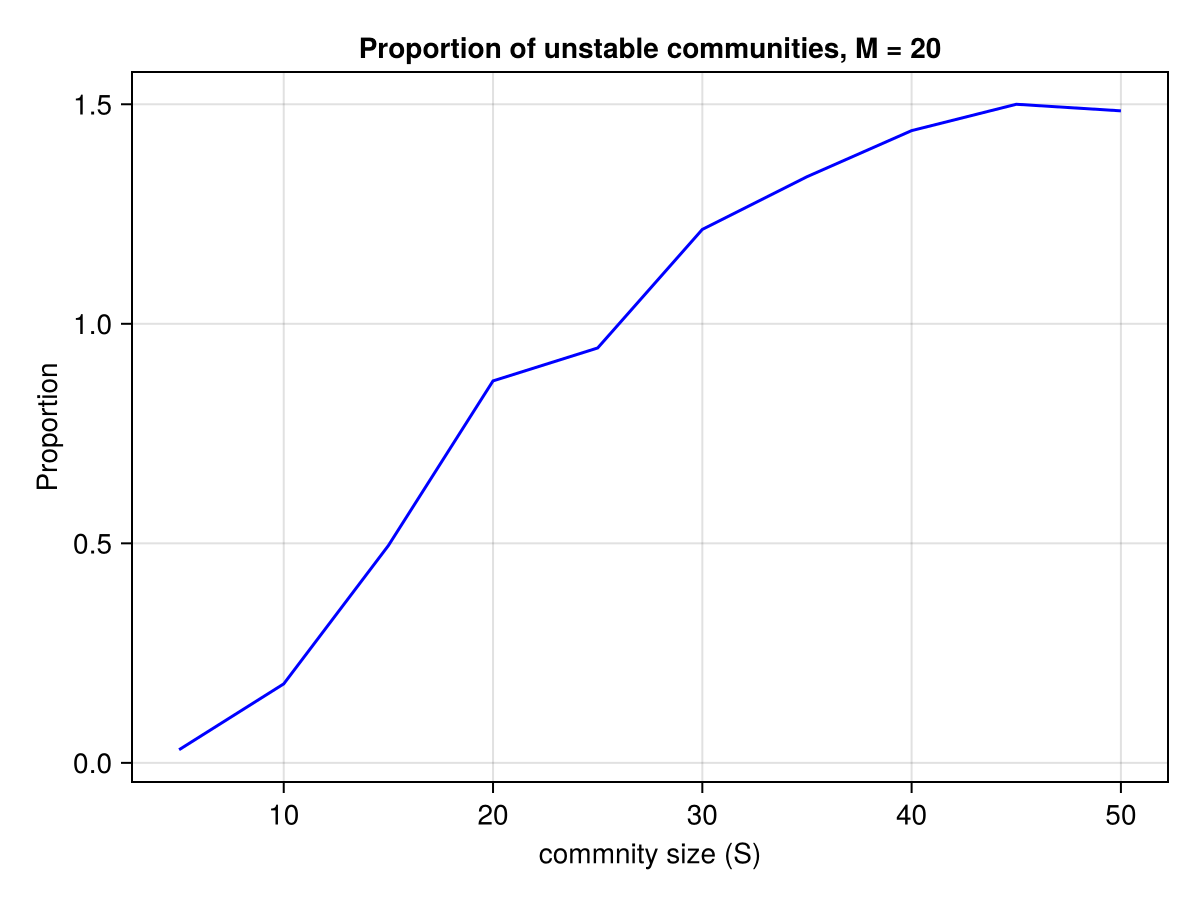

CairoMakie.Screen{IMAGE}


In [17]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities, M = 20", xlabel="commnity size (S)", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

# Things I want to save for reference!

## First high instability sampler

In [213]:
rsg = RSGJans1(20, 20;
    m=0.9, # increasing m we quickly lose them!
    r=0.2,
    Kp=0.2, K=0.5,
    
    c=4.,
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)
@time xx = example_do_rg_run(rsg, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6
)
freqtable(xx)

Generating one params: 0.000020 seconds (153 allocations: 92.625 KiB)
  2.313998 seconds (26.95 M allocations: 4.488 GiB)


1-element Named Vector{Int64}
Dim1  │ 
──────┼────
1     │ 100

In [106]:
@time yy = example_do_rg_run(rsg, 1, LinRange(0., 100., 1000),
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6,
    return_interesting=true
)
@show length(yy[2])
freqtable(yy[1])

Generating one params: 0.000012 seconds (42 allocations: 12.844 KiB)
  0.012593 seconds (48.18 k allocations: 35.942 MiB)
length(yy[2]) = 0


1-element Named Vector{Int64}
Dim1  │ 
──────┼──
1     │ 1

In [88]:
ps = yy[2][1];

# Running a single system

In [40]:
ps = rsg();

## No space solver

In [89]:
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF()); reltol=1e-9);
maximum(abs, sss.resid)

  0.002248 seconds (1.30 k allocations: 262.016 KiB)


8.89638261349542e-9

maximum(abs, (s.u[end])[1:(get_Ns(ps))[1]]) = 6.0


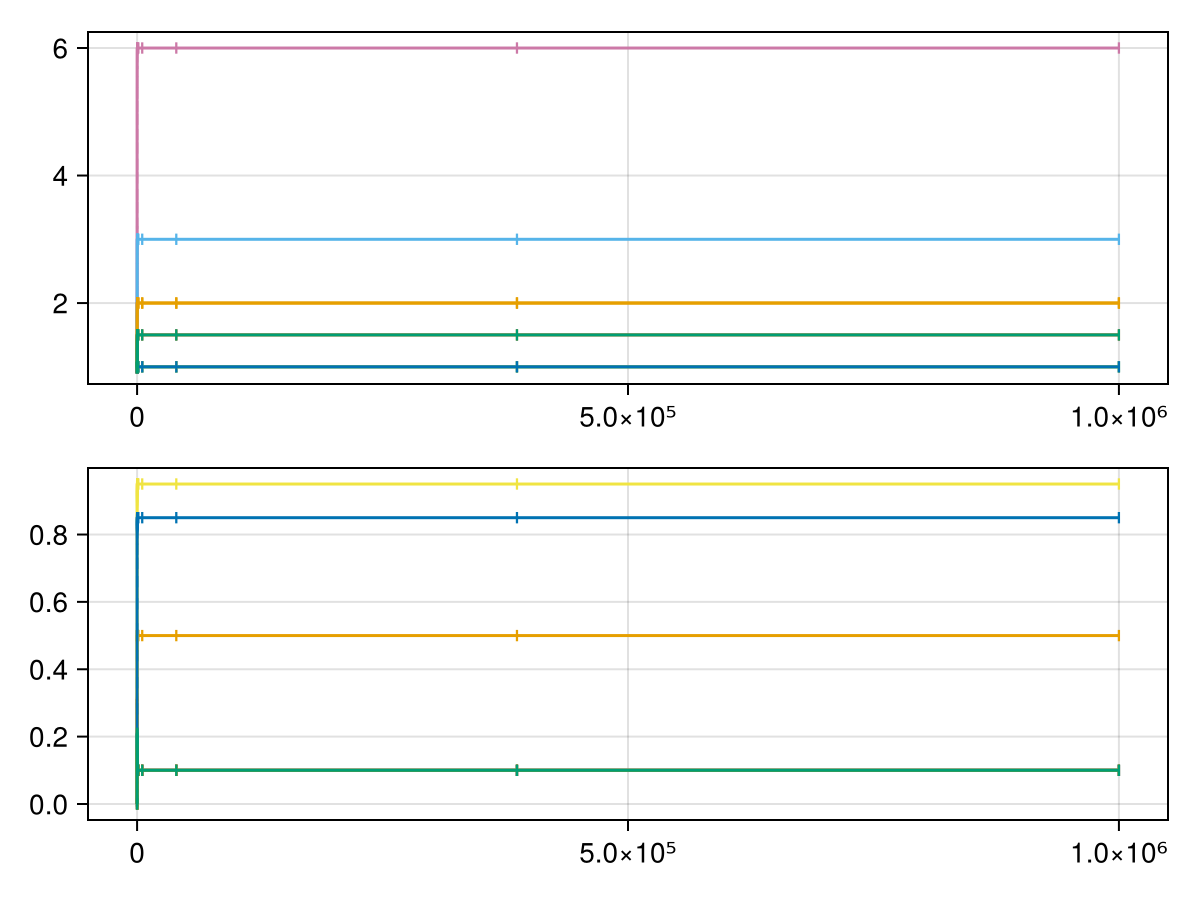

In [90]:
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 1000000);

s = solve(p)
@show maximum(abs, s.u[end][1:get_Ns(ps)[1]])

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

## Spatial stuff

In [91]:
nssol = s.u[end];
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 3.3306690738754696e-16


### Linear stability

In [92]:
ks = LinRange(0., 100., 1000)

lamfunc = linstab_make_k_func(ps, nssol)
lambdas = lamfunc.(ks);

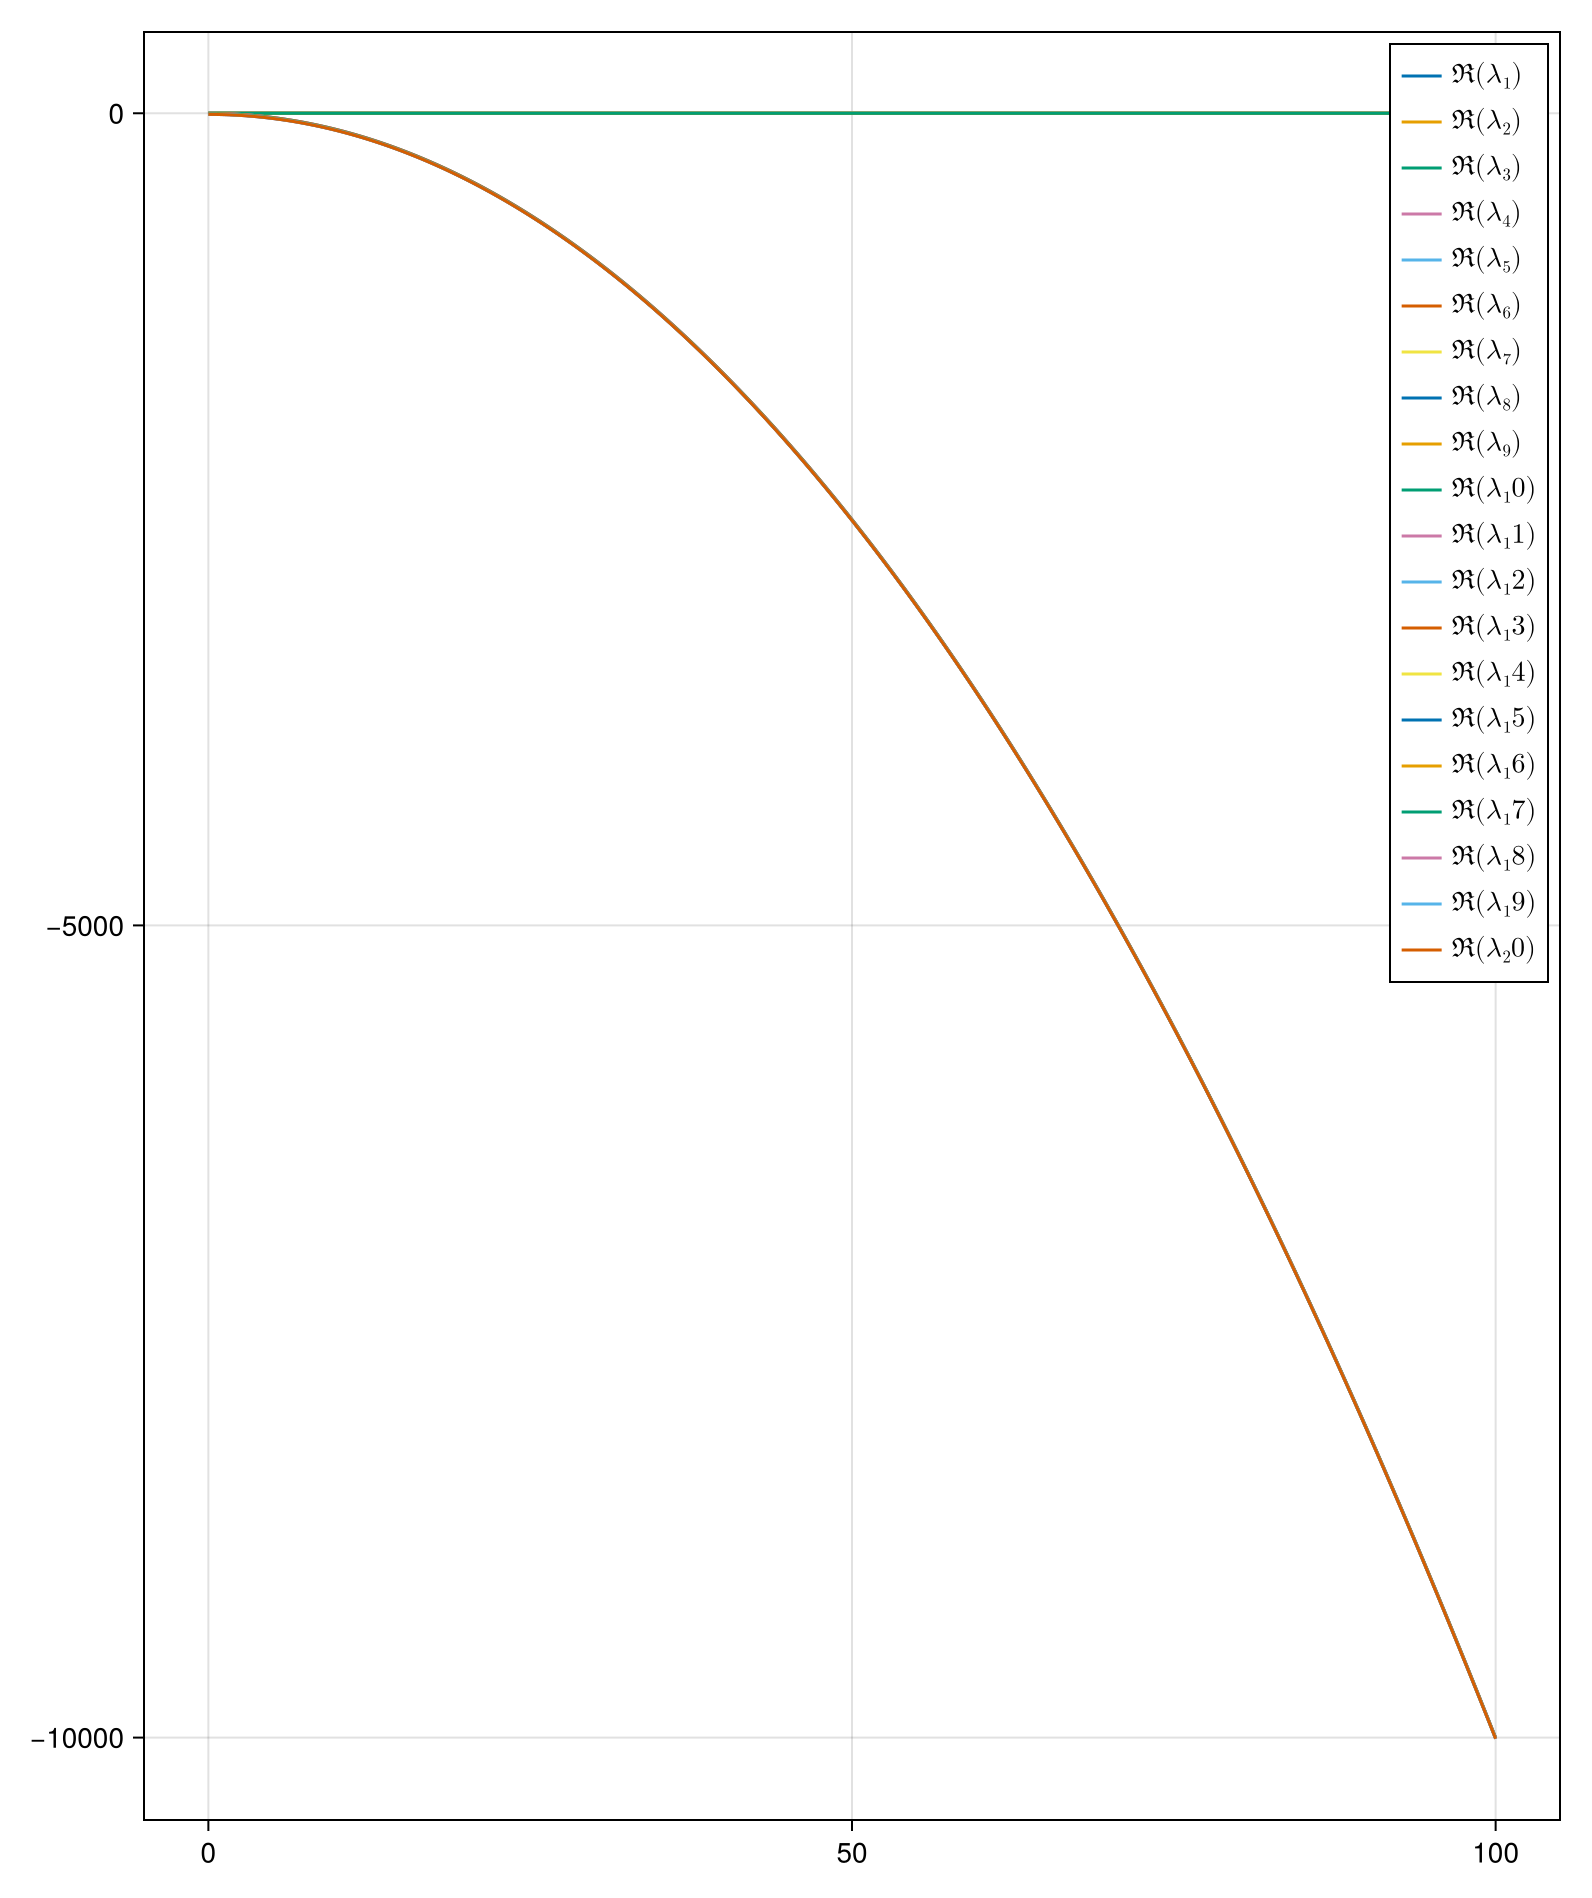

In [93]:
faa = plot_linstab_lambdas(ks, lambdas)
display(GLMakie.Screen(), faa.figure)
faa

### 1D spatial

In [89]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [90]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

 20.937264 seconds (128.32 k allocations: 5.782 GiB, 2.01% gc time)
Success
nf is 880
solution has 150 saved states
max resid is 2.00273e-11


┌ Warning: reaching negative values, minimum is -3.32617e-06
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


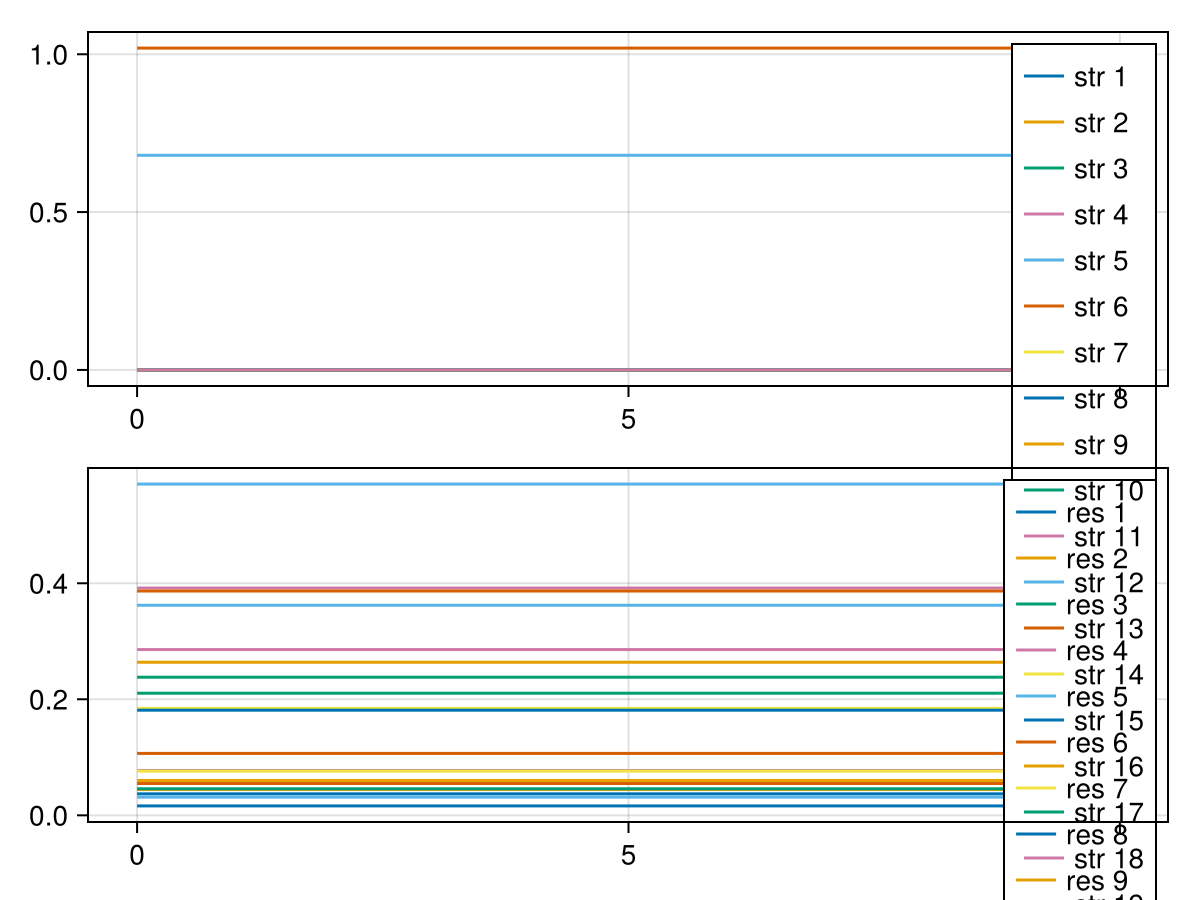

In [105]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[150])

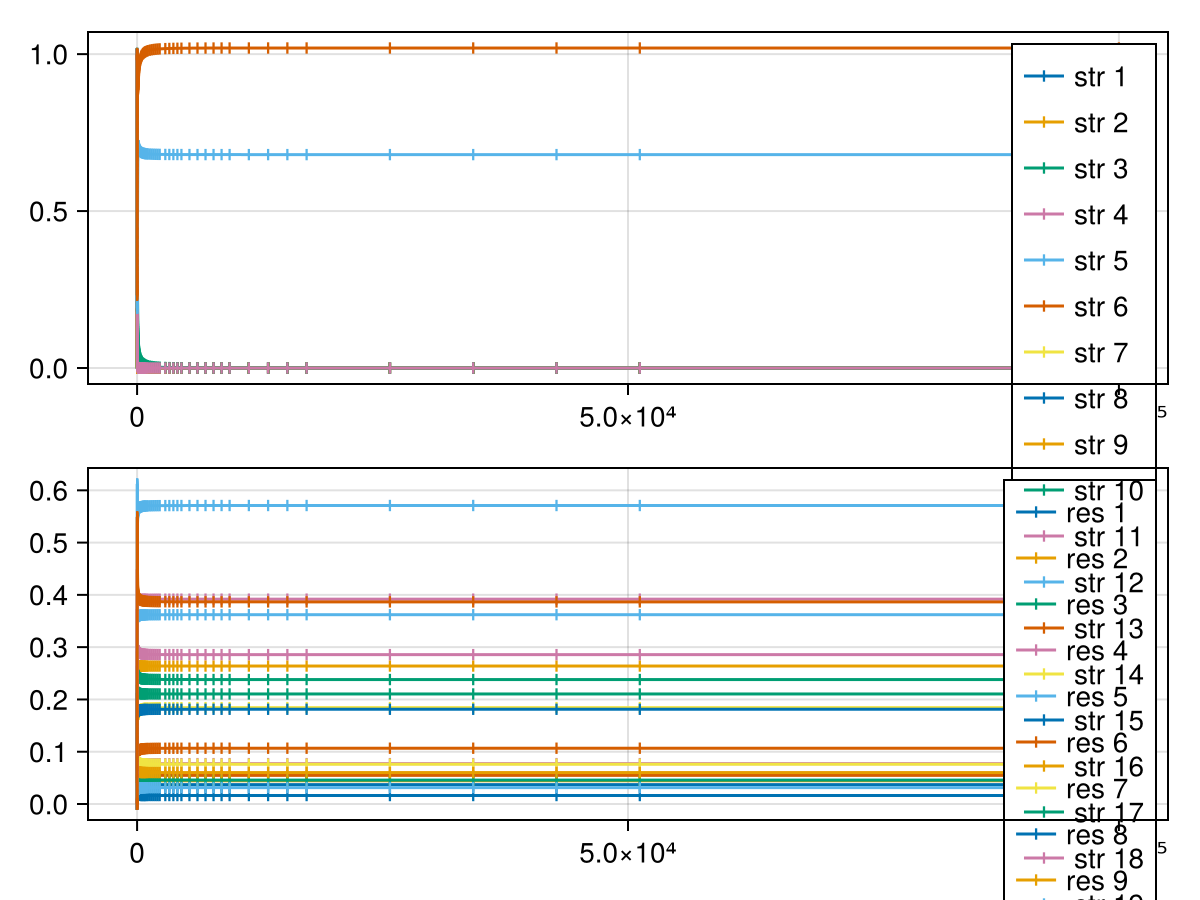

In [92]:
plot_smmicrm_sol_avgs(sps)

# Running Stevens generator

In [44]:
rsg = RSGStevens1(20, 20, 1., 0.35);
@time xx = do_rg_run(rsg, 1000, LinRange(0., 40., 10000);
    extinctthreshold=1e-5
)
freqtable(xx)

Generating one params: 0.033824 seconds (40.34 k allocations: 8.685 MiB)
maxresid reached is 0.000011 > 0.000010maxresid reached is 0.000011 > 0.000010maxresid reached is 0.000042 > 0.000010maxresid reached is 0.000995 > 0.000010

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/7BHQj/src/integrator_interface.jl:589


487.655912 seconds (428.92 M allocations: 371.603 GiB, 6.12% gc time, 0.00% compilation time)


5-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   5
-100  │   1
-1    │   4
1     │ 979
2     │  11

# Bigger runs

In [114]:
bigrsg = RSGJans1(50, 50;
    m=1.,
    r=1.,
    Kp=0.1, K=10.0,
    
    c=(2., 1.),
    l=0.2,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)

@time xx = do_rg_run(rsgj, 1000, LinRange(0., 1000., 1000);
    extinctthreshold=1e-5
)

jldsave(datadir("randomsystems/prelim", randname()*".jld2");
    rsg=bigrsg,
    output=xx
)

freqtable(xx)

Generating one params: 0.000501 seconds (865 allocations: 1.265 MiB)
451.332197 seconds (3.80 G allocations: 174.887 GiB, 4.30% gc time, 0.00% compilation time)


3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │  14
1     │ 985
2     │   1

# Looking/comparing saved data

In [128]:
f = jldopen("../data/randomsystems/prelim/Proactive-Fuchsia-Mongoose.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   9
1     │ 987
2     │   4

In [134]:
f = jldopen("../data/randomsystems/prelim/Likable-Periwinkle-Viper.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   2
1     │ 994
2     │   4

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()